## Removing Bell Krater Handles

### Plan:

1. With the SKImage function 'find_contours' (which uses the _Marching squares method_) find the contour depicting the pot outline.
1. Choose a side, left or right.
1. Estimate location of handle*. 
1. Look for points in that estimated area, that stick out. We assume that these points will be the handle of the pot. Label the top and bottom of the handle as $p_{1}$ and $p_{2}$ respectively.
1. Starting from the top of the pot, travel along the pot until you get to $p_{1}$. From here, cut straight to $p_{2}$ and then continue traversing along the pot contour until you reach the bottom of the pot.

### Code:

#### Imports

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pylab as pl
from math import sqrt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import re
import itertools as it
import csv
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
pl.ion()

#### Contour Outline Function

In [8]:
def get_outline_contour(img):
    
    # Get all contours:
    thresh = threshold_otsu(img)
    binary = img > thresh
    cont = measure.find_contours(binary, 0.8)
    
    # Find longest contour:
    cont_ln = []
    for n, contour in enumerate(cont):
        cont_ln.append(len(contour))

    longest_c = sorted(cont_ln,reverse=True)[:20]
    long_ind = []
    for i in range(0,len(cont_ln)):
        if cont_ln[i] in longest_c:
            long_ind.append(i)
            
    return cont[long_ind[0]]

#### Handle Removal Code:

In [21]:
def get_shortest_side(X,Y):
    top_pnt = np.argmax(Y)
    bot_pnt = np.argmin(Y)

    mx_pnt = max(top_pnt,bot_pnt)
    mn_pnt = min(top_pnt,bot_pnt)

    xs1 = list(X[mn_pnt:mx_pnt])
    ys1 = list(Y[mn_pnt:mx_pnt])

    xs2 = list(X)[mx_pnt:] + list(X)[:mn_pnt] 
    ys2 = list(Y)[mx_pnt:] + list(Y)[:mn_pnt] 
    
    if min(xs1) > min(xs2):
        D1 = "R"
        D2 = "L"
    else:
        D1 = "L"
        D2 = "R"

    if len(ys1) >= len(ys2):
        ys = ys2
        xs = xs2
        D = D2
    else:
        ys = ys1
        xs = xs1
        D = D1

    return xs,ys,D

In [25]:
def smooth_side_contour(x,y,direction):
    
    ys = sorted(y)
    ys = np.unique(np.round(ys))
    y = np.round(y)
    x = np.round(x)
        
    xs = []
    for i in range(0,len(ys)):
        inds = np.where(y==ys[i])
        xy = x[inds]
        if direction == 'R':
            xs.append(max(xy))
        else:
            xs.append(min(xy))
            
    return xs,ys

In [26]:
def get_bkrater_contour(img):
    
    # 1) Get pot outline contour:
    pot = get_outline_contour(img)
    
    # 2) Get shortest side of outline:
    x = pot[:,1]
    y = pot[:,0]
    x_,y_,D = get_shortest_side(x,y)
    
    # 3) Make contour side smoother:
    xs,ys = smooth_side_contour(x_,y_,D)
    
    # 4) Find positions where handle starts and ends:
    # We predict that handle will fall between the 10th and
    # 40th percentile of the pot (from the top down)
    tnth = (max(ys) - min(ys))/10
    lb = min(ys) + tnth
    ub = lb + 4*tnth
    indents = []
    for i in range(1,len(xs)-1):
        if lb < ys[i] < ub:
            if D == 'R':
                if xs[i] <= xs[i-1] and xs[i] < xs[i+1]:
                    indents.append(i)
            else:
                if xs[i] >= xs[i-1] and xs[i] > xs[i+1]:
                    indents.append(i)
    
    p2 = indents[-1]
    p1 = indents[0]
    
    # 5) Get refined contour by cutting through handle:
    xsr = []
    ysr = []
    xsr.extend(xs[:p1])
    ysr.extend(ys[:p1])
    xsr.extend(xs[p2:])
    ysr.extend(ys[p2:])
        
    return xsr,ysr

#### Test:

In [6]:
image_grey = data.load('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images\\bellkrater_574_Vienna.bmp',as_gray=True)

In [27]:
x,y = get_bkrater_contour(image_grey)

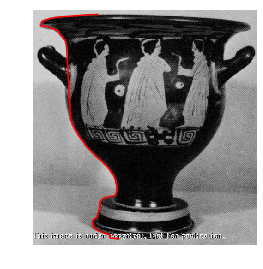

In [29]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(image_grey, cmap="gray")
ax.set_axis_off()
ax.plot(x,y,'-r')